# Финальный проект "Детекция наличия на лице человека медицинской маски"

## 1. Обоснование выбора темы проекта



Маски для лица стали жизненно важным элементом нашей повседневной жизни за время глобальной пандемии (COVID-19). Поэтому их ношение важно для безопасности и контроля распространения вируса. Медицинские маски способны значительно снизить уровень распространения смертельного вируса. По мере того как мы начали продвигаться вперед в этом "новом нормальном" мире, необходимость в маске для лица возросла. На сегодняшний день актуальным является вопрос контроля наличия маски на людях в общественных местах (торговых центрах, магазинах, кафе, ресторанах и так далее). В большинстве случаев сегодня эта задача решается с помощь человеческого труда или не контролируется должным образом. 
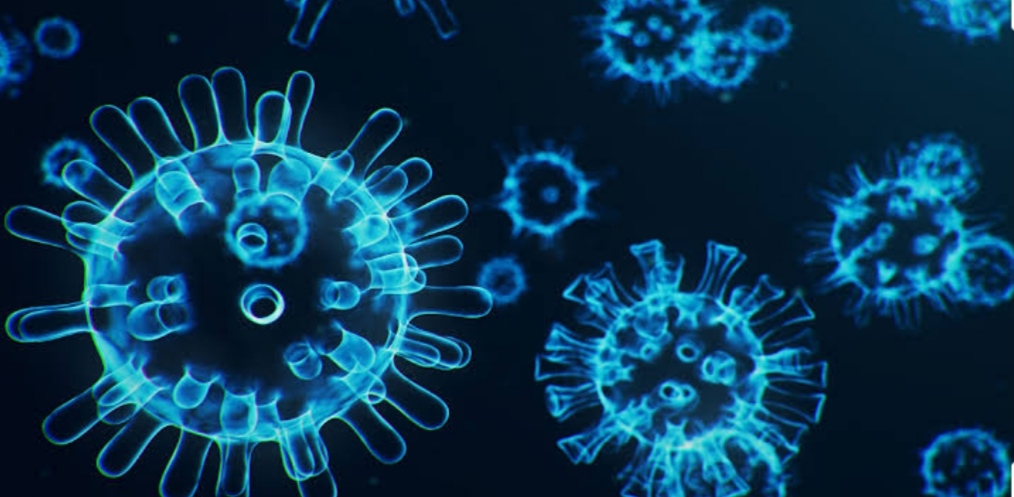

Целью данного проекта является ограничение возможности людей совершать различные операции в общественных местах без наличия медицинской маски автоматическим способом.
Для достижения поставленной цели в проекте придется решить следующие задачи:

*   Определить критерии правильно надетой на человека маски
*   Определить критерии выбора механизмов для реализации проекта
*   Рассмотреть возможные варианты внедрения полученных результатов в повседневную жизнь.


**Применимость результатов**. С помощью результатов данного проекта можно будет осуществлять, например, следующие виды контроля:


*   Контроль наличия медицинской маски на посетителе торгового центра/магазина (пример решения в Азии: https://twitter.com/larrykim/status/1318243765979615233?s=21)
*   Контроль наличия медицинской маски на покупателе в магазине на кассе – при наличии маски может активироваться терминал оплаты.
*   Контроль наличия медицинских масок на посетителях общественного транспорта, а также подсчет нарушителей режима. Информация может поступать на пульт диспетчерской)

Для реализации данного проекта определены **следующие этапы**:
1.	Определение критериев правильности надетой на человеке маски
2.	Сбор и разметка данных для обучения по сформированным категориям
3.	Определение критериев выбора механизмов реализации распознавания маски на лице человека
4.	Обучение модели
5.	Тестирование модели на потоковом видео
6.	Подведение итогов эксперимента


**Этап 1. Определение критериев правильности надетой на человеке маски**
Для того, чтобы приступить к сбору данных и формированием датасета для обучения необходимо определиться с критериями правильности надевания медицинской маски человеком. Например, на сегодняшний день люди могут носить маску на подбородке, не закрывая нос и так далее. Как мы будем их классифицировать. 
В рамках текущего проекта мы выделим 2 класса для идентификации наличия маски на человеке:

*   Маска надета – критерием для данного класса будет следующее расположение маски: маска закрывает нос человека, и маска закрывает рот человека
*   Маска не надета – критерием для данного класса будет полное отсутствие маски на лице человека

	*Неправильно надетую маску: маска не закрывает нос, маска не закрывает рот человека будем классифицировать, как отсутствие маски.*

**Этап 2. Сбор и разметка данных для обучения по сформированным категориям**
Для формирования датасета были использованы открытые источники. По итогам сбора данных фотографии людей были классифицированы в соответствии с определенными для проекта критериями. Итого для будущего обучения собрано следующее количество фотографий людей:

*   Фотографии с людьми в масках - 1059 шт.
*   Фотографии людей без масок 686 шт.


Загрузим необходимые библиотеки:



In [ ]:
import tensorflow as tf
import numpy as np
from imutils import paths
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import Callback
from sklearn import preprocessing
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2

In [ ]:
!pip install opencv-python

Разметим полученные данные в соответствии с критериями классификации (данные лежат на google drive)

In [ ]:
import os

data_path='/content/drive/MyDrive/final project SF/Data'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [ ]:
for _,_,files in os.walk('/content/drive/MyDrive/final project SF/Data/without_mask'):
    print('Количество фотографий людей без масок:', len(files))

Количество фотографий людей без масок: 686


In [ ]:
for _,_,files in os.walk('/content/drive/MyDrive/final project SF/Data/with_mask'):
    print('Количество фотографий с людьми в масках:', len(files))

Количество фотографий с людьми в масках: 1059


In [ ]:
imagePaths = list(paths.list_images (r'/content/drive/MyDrive/final project SF/Data'))

Преобразуем фотографии

In [ ]:
data , labels = [] , []
for imagePath in imagePaths:
  ##Извлечение класса из директории (с маской или без)
  label = imagePath.split(os.path.sep)[-2]
  ##Загружам входное изображение 224х224 и обрабатываем его
  img = cv2.imread(imagePath)
  resized=cv2.resize(img,(224, 224))
  ##Обновляем список файлов и классов
  data.append(resized)
  labels.append(label)

In [ ]:
# Переводим в NumPy массив
data = np.array(data, dtype="float32")/255.0
data=np.reshape(data,(data.shape[0],224,224,3))
labels = np.array(labels)
print(labels)

['without_mask' 'without_mask' 'without_mask' ... 'with_mask' 'with_mask'
 'with_mask']


In [ ]:
le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels)
print(labels)

[1 1 1 ... 0 0 0]


In [ ]:
le.classes_

array(['with_mask', 'without_mask'], dtype='<U12')

In [ ]:
labels = to_categorical(labels)

In [ ]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

**Этап 3. Определение критериев выбора механизмов реализации распознавания маски на лице человека**

Перед тем как переходить к определению критериев нам необходимо определиться с перечнем технологий и подходов, которые будут использованы в данном проекте. Верхнеуровнево в проекте необходимо обучить модель по фотографиям различать то, как надета маска на человека и далее применить обученную модель для распознавания медицинской маски на потоковом видео. Для этого нам в проекте потребуются следующие технологии:
1.	Архитектура нейросети – «голова» для transfer learning и fine-tuning
2.	Датасет, на котором была предобучена «голова» нашей нейросети

**Архитектура нейросети**
Основным критерием при выборе архитектуры сети для распознавание медицинских масок на потоковом видео является ее легковесность. Данный критерий повлияет как на время обучения, так и на время ее работы на реальных данных. В связи с тем, что функционал по большей части будет реализовываться на портативных устройствах, то их мощности и памяти должно хватать для обработки потока видео и распознавания с должной частотой на нем медицинской маски и лиц людей.
Для решения стоящих перед проектом задач была выбрана архитектура нейросети MobileNetV2. Сравним между собой несколько архитектур сетей. Возьмем для примера Xception, о котором был прошлый пост, глубокую и старую VGG16, а также несколько вариаций MobileNet
Архитектура сети	Количество параметров	Top-1 accuracy	Top-5 accuracy
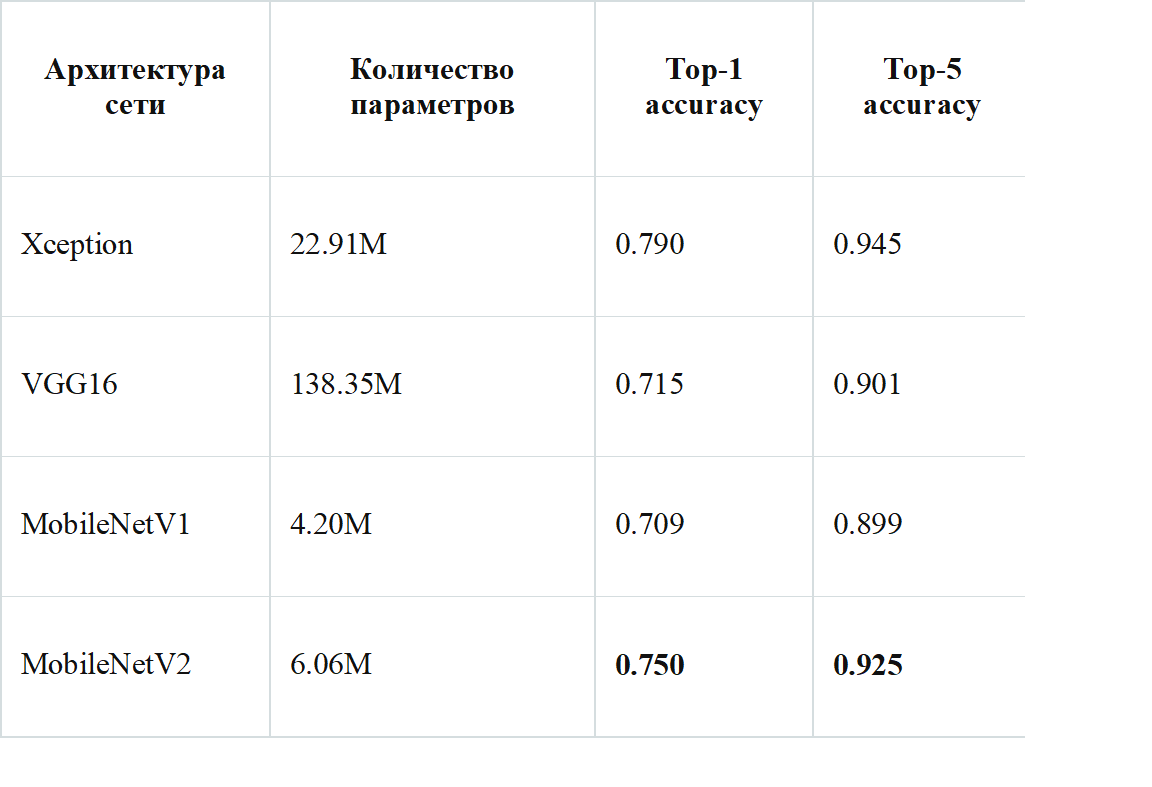
Также, в статье про MobileNetV2 показываются весьма интересные результаты на других задачах. В частности, авторы демонстрируют, что SSDLite-архитектура для задачи object detection, использующая MobileNetV2 в свёрточной части, превосходит известный детектор реального времени YOLOv2 по точности на датасете MS COCO, при этом показывая в 20 раз большую скорость и в 10 раз меньший размер (в частности, на смартфоне Google Pixel сеть MobileNetV2 позволяет делать object detection с 5 FPS).
Для проекта выбираем MobileNetV2 предобученную на датасете ImageNet. 

**Этап 4. Обучение нейросети**

In [ ]:
INIT_LR = 1e-4
EPOCHS = 30
BS = 32

In [ ]:
# Разобьём датасет  на тренировочный и тестовый 80% на 20%;
(trainX, testX, trainY, testY) = train_test_split(data, labels,  test_size = 0.20, stratify = labels, random_state = 42)

В связи с тем, что в исходном датасете количество изображений не очень большое, добавим аугментированные изображения для обучений нейросети

In [ ]:
!pip install --upgrade albumentations -q
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor -q

     |████████████████████████████████| 98 kB 7.9 MB/s 
     |████████████████████████████████| 37.1 MB 44 kB/s 
     |████████████████████████████████| 49.9 MB 14 kB/s 


In [ ]:
import tensorflow as tf
from ImageDataAugmentor.image_data_augmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    GaussNoise, GaussNoise, MotionBlur, MedianBlur, PiecewiseAffine,
    Sharpen, Emboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

AUGMENTATIONS = albumentations.Compose([
    HorizontalFlip(),
    OneOf([
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        PiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        Sharpen(),
        Emboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1) 

In [ ]:
datagen = ImageDataAugmentor(
    featurewise_center=True,
    featurewise_std_normalization=True,
    augment=AUGMENTATIONS, 
    validation_split=0.2
)

В даном проекте мы использовали голову mobileNetv2 без разморозки части слоев (fine-tuning) в связи с тем, что результаты показанные при обучении и так достаточно высокие.

In [ ]:
# Загружаем базовую модель c предварительно обученными весами
##path_weights = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'    
baseModel = MobileNetV2(weights="imagenet", 
include_top=False, input_tensor=Input(shape=(224, 224, 3)))
##Запишем в нашу модель внешний слой из базовой модели
headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (7, 7))(headModel)
headModel = Flatten(name = "flatten")(headModel)
headModel = Dense(128, activation = "relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation = "softmax")(headModel)
model = Model(inputs = baseModel.input, outputs = headModel)
# Заморозка слоев базовой модели 
for layer in baseModel.layers:
	layer.trainable = False
# Скомпилируем нашу модель
opt = Adam(learning_rate = INIT_LR, decay = INIT_LR / EPOCHS)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

In [ ]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	datagen.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
  callbacks = callbacks_list
  )

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
#print(classification_report(testY.argmax(axis=1), predIdxs,
#	target_names=lb.classes_))

[INFO] training head...


/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:539: UserWarning: This ImageDataAugmentor specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataAugmentor specifies '
/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:547: UserWarning: This ImageDataAugmentor specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataAugmentor specifies '


Epoch 1/30
43/43 [==============================] - 50s 435ms/step - loss: 0.6842 - accuracy: 0.6349 - val_loss: 0.2819 - val_accuracy: 0.9742

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
43/43 [==============================] - 17s 403ms/step - loss: 0.4825 - accuracy: 0.7720 - val_loss: 0.1422 - val_accuracy: 0.9828

Epoch 00002: saving model to best_model.hdf5
Epoch 3/30
43/43 [==============================] - 20s 468ms/step - loss: 0.4127 - accuracy: 0.8013 - val_loss: 0.0916 - val_accuracy: 0.9857

Epoch 00003: saving model to best_model.hdf5
Epoch 4/30
43/43 [==============================] - 20s 462ms/step - loss: 0.3792 - accuracy: 0.8065 - val_loss: 0.0651 - val_accuracy: 0.9857

Epoch 00004: saving model to best_model.hdf5
Epoch 5/30
43/43 [==============================] - 20s 461ms/step - loss: 0.3554 - accuracy: 0.8152 - val_loss: 0.0503 - val_accuracy: 0.9857

Epoch 00005: saving model to best_model.hdf5
Epoch 6/30
43/43 [==============================] - 18s 416ms/step - loss: 0.3291 - accuracy: 0.8174 - val_loss: 0.0424 - val_accuracy: 0.9885

Epoch 00006: saving model to best_model.hdf5
Epoch 7/30
43/43 [==============================] - 18s

Обучение останавливается раньше максимального количества эпох ввиду достижения платов обучении.

In [ ]:
model.save('/content/drive/MyDrive/final project SF/mask_recogn2_two_classes.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Мы сохранили полученную модель для ее дальнейшего использования для обработки потокового видео. Работа с потоковом видео рассматривается в рамках отдельного ноутбука (Part 2)